In [ ]:
# Andrii Korolov

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay # confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split # автоматическое разделение данных на 80/20
from sklearn.model_selection import cross_validate # перекрестная проверка

## Идентификация мошенников среди покупателей в онлайн-магазине

#### Customers_final_ex.csv — данные о покупателях
Описание:
* Customer_id — уникальный идентификатор учетной записи клиента
* age — возраст клиентского счета в месяцах (может быть float)
* num_s — количество посылок, отправленных на адрес, по которому покупатель не проживает в течение последнего месяца
* num_dev — количество различных физических устройств (смартфонов, планшетов, ПК), связанных на данный момент с учетной записью
* gender — мужчина, женщина, другое или нет информации
* Preferred color — предпочтительный цвет заказчика

#### Transactional_info_new.csv — данные о покупках этих покупателей в последнем месяце
Описание:
* transaction_id — уникальный идентификатор покупки
* Dist — расстояние между адресом доставки и домашним адресом в км
* payment_t — тип платежа: 0 — безопасный (кредитные карты, PayPal и т. д.) 1— небезопасный (счет, рассрочка)
* count_dev_is_shop — страна, в которой находится устройство, с которого была совершена транзакция, идентифицируется по IP-адресу, идентична стране магазина (0 — да, 1 — нет)
* basket — стоимость покупки
* product_type — ценность товара в зависимости от типа товара
* Fraudulent_Trans — отметка, считалась ли транзакция мошеннической (истинное значение)
* Customer_id — идентификатор учетной записи клиента, в которой была создана эта транзакция
* Day_of_Week — день недели, когда была создана транзакция (0 - воскресенье, 1 - понедельник и тд)


#### Задание: 
* Проведите анализ полученных данных. Выберите метод анализа из изученных на курсе, обоснуйте свой выбор.
* Проанализируйте, какие факторы важны для находки покупок мошенников, какие нет? 
* Создайте модель, которая будет предсказывать на будущее Fraudulent_Trans. 

In [24]:
customers = pd.read_csv('Customers_final_ex.csv',index_col=0)
transactions = pd.read_csv('transactions_final_ex.csv',index_col=0)


In [ ]:
# анализ факторов, влияющих на выявление мошенника

In [74]:
transactions.dropna(inplace=True)
X = transactions['Dist']
y = transactions['Fraudulent_trans']

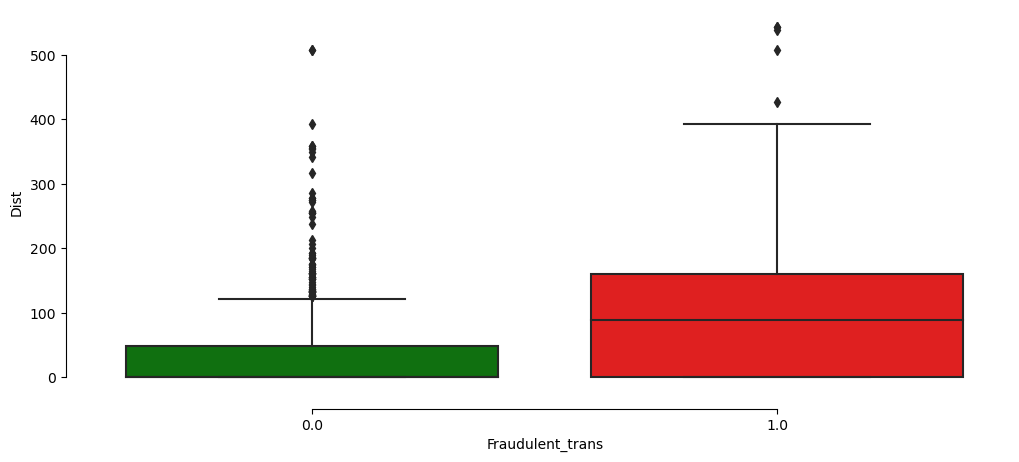

In [25]:
# проверяем предикат "расстояние между адресом доставки и домашним адресом"
fig, ax = plt.subplots(1,figsize=(12,5))
sns.boxplot(x="Fraudulent_trans", y="Dist",
            palette=["g", "r"],
            data=transactions)
sns.despine(offset=10, trim=True)
# Судя по боксплоту, расстояние между адресом доставки и домашним адресом имеет значение. В мошеннических транзакциях расстояние
# часто больше.

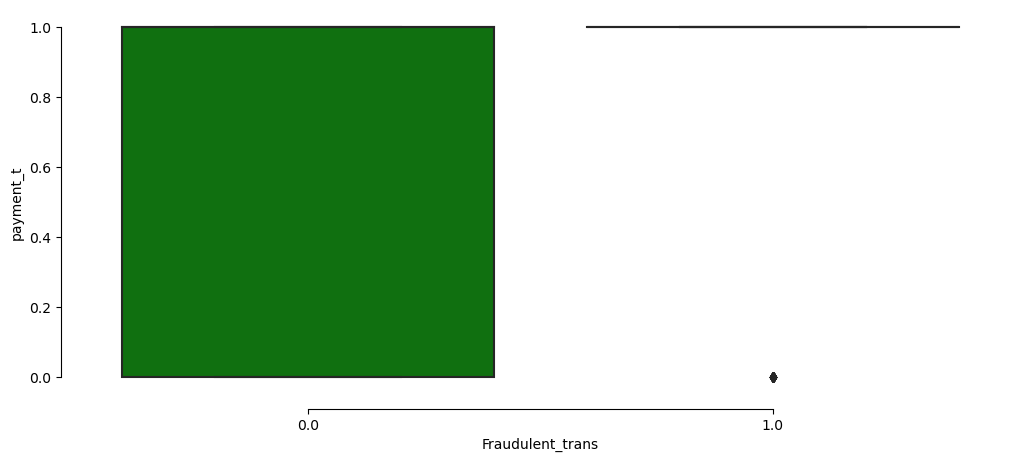

In [26]:
# проверяем предикат "тип платежа"
fig, ax = plt.subplots(1,figsize=(12,5))
sns.boxplot(x="Fraudulent_trans", y="payment_t",
            palette=["g", "r"],
            data=transactions)
sns.despine(offset=10, trim=True)
# мы видим, что "хорошоие" транзакции оплачивались как безопасным, так и небезопасным способом, в то время, как в мошеннических
# транзакциях оплата шла преимущественно небезопасным способом. Мы можем использовать этот параметр для поиска.

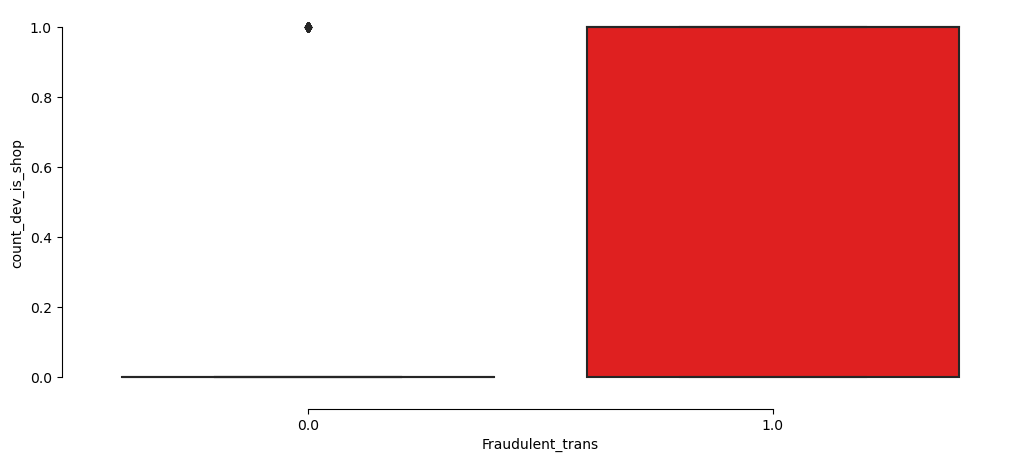

In [29]:
# проверяем предикат " страна, в которой находится устройство, с которого была совершена транзакция"
fig, ax = plt.subplots(1,figsize=(12,5))
sns.boxplot(x="Fraudulent_trans", y="count_dev_is_shop",
            palette=["g", "r"],
            data=transactions)
sns.despine(offset=10, trim=True)
# Основная часть безопасных транзакций велась из страны, соответствующей локации магазина, в то время как небезопасные рапределены
# более равномерно. Скорее весго, этот параметр подходит для поиска.

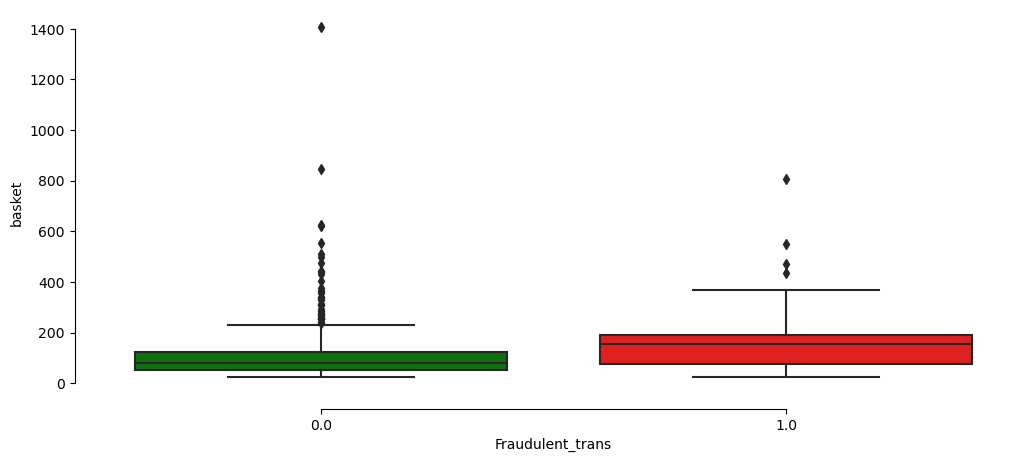

In [32]:
# проверяем предикат "стоимость покупки"
fig, ax = plt.subplots(1,figsize=(12,5))
sns.boxplot(x="Fraudulent_trans", y="basket",
            palette=["g", "r"],
            data=transactions)
sns.despine(offset=10, trim=True)
# На мой взгляд, исходя из боксплота, от стоимости покупки сложно отталкиваться.

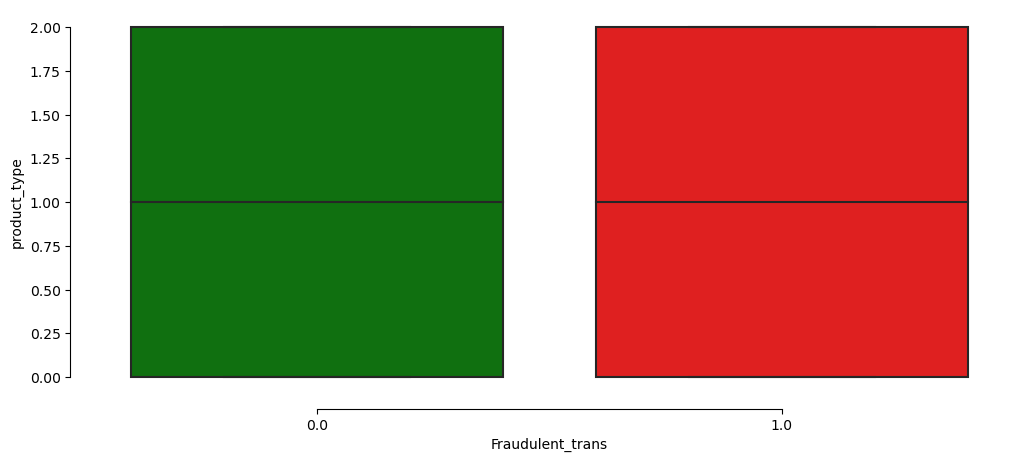

In [33]:
# проверяем предикат "ценность товара в зависимости от типа товара"
fig, ax = plt.subplots(1,figsize=(12,5))
sns.boxplot(x="Fraudulent_trans", y="product_type",
            palette=["g", "r"],
            data=transactions)
sns.despine(offset=10, trim=True)
# Исходя из боксплота, от ценность товара мы отталкиваться не можем.

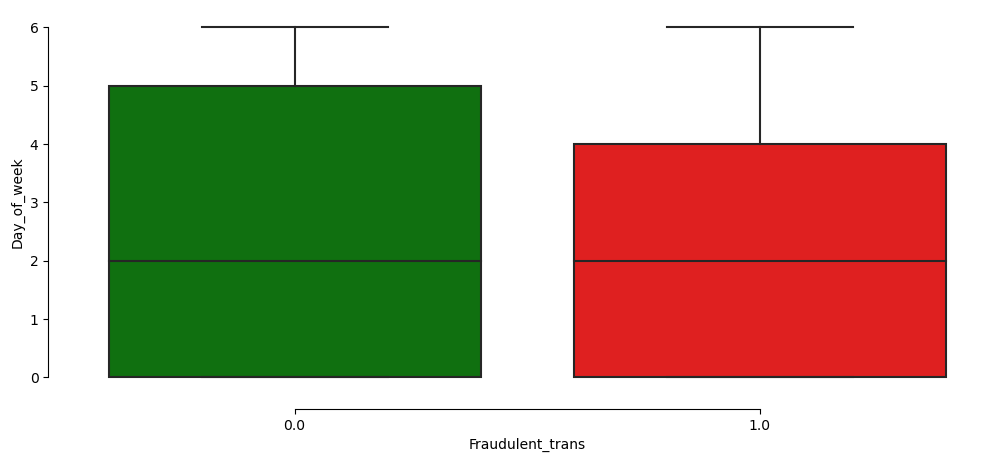

In [36]:
# проверяем предикат "день недели, когда была создана транзакция"
fig, ax = plt.subplots(1,figsize=(12,5))
sns.boxplot(x="Fraudulent_trans", y="Day_of_week",
            palette=["g", "r"],
            data=transactions)
sns.despine(offset=10, trim=True)
# Хотя прослеживается небольшая разница между тем, в какой день недели совершается транзакия, но разница эта не слишком незначителная
# и может больше мешать обучению модели, чем помогать.

In [145]:
# На основании датафрейма transactions, где у нас отмечены мошеннический трансакции, посредством фильтра и выноса id 
# пользователей, которые совершали такие трансакции, мы создаём новую колонку "is_fraudster" в датафрейме пользователей.
# Это даёт нам возможность проследить, можно ли использовать какие-то данные из этого датафрейма в качестве предиката.
fraudster_transactions = transactions[transactions['Fraudulent_trans'] == 1]
transactions_uniq_by_customer = fraudster_transactions.drop_duplicates(subset=['Customer_id'])
fraudsters_ids = transactions_uniq_by_customer['Customer_id'].values
ext_customers = customers.copy()
ext_customers['is_fraudster'] = 0
for index, cust in ext_customers.iterrows():
    if index in fraudsters_ids:
        ext_customers.at[index, 'is_fraudster'] = 1

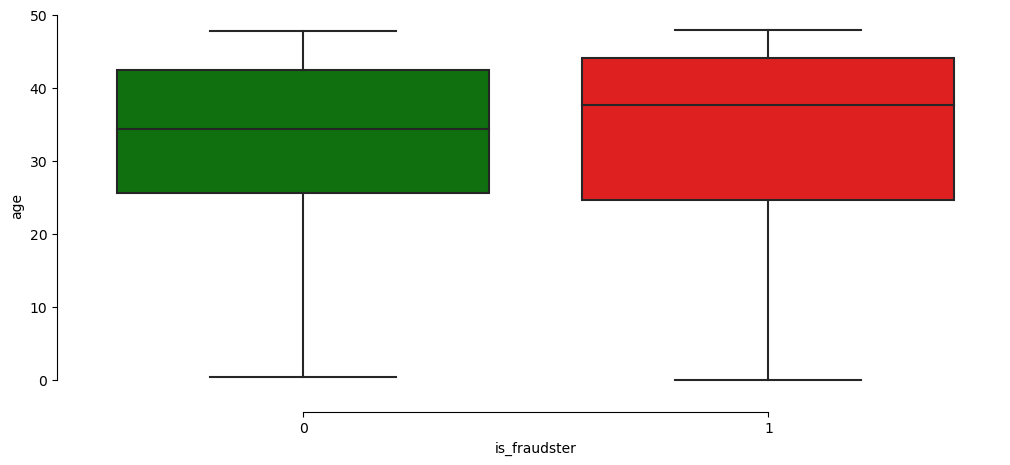

In [68]:
# проверяем предикат "возраст клиентского счета в месяцах"
ext_customers.dropna(inplace=True)
X = ext_customers['age']
y = ext_customers['is_fraudster']
fig, ax = plt.subplots(1,figsize=(12,5))
sns.boxplot(x="is_fraudster", y="age",
            palette=["g", "r"],
            data=ext_customers)
sns.despine(offset=10, trim=True)
# Исходя из боксплота, я не стал бы брать этот параметр как предикат.

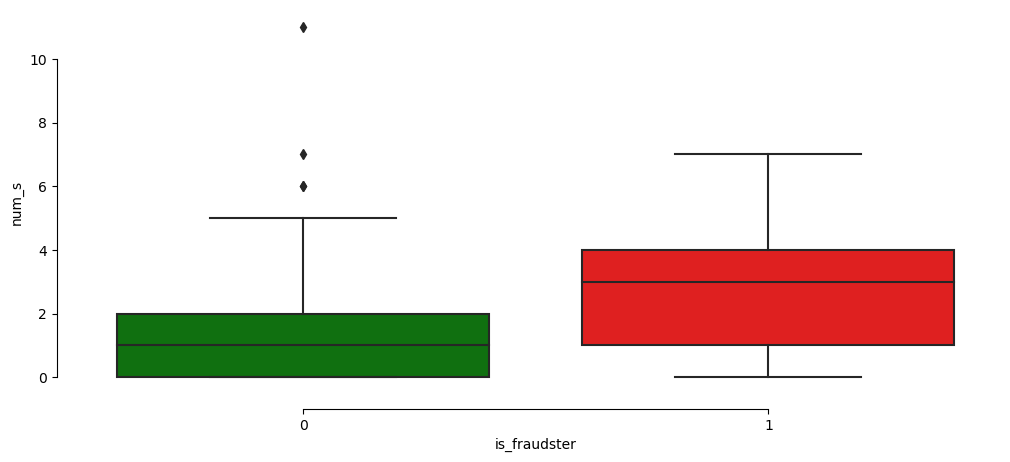

In [69]:
# проверяем предикат "количество посылок в течении месяца"
ext_customers.dropna(inplace=True)
X = ext_customers['num_s']
y = ext_customers['is_fraudster']
fig, ax = plt.subplots(1,figsize=(12,5))
sns.boxplot(x="is_fraudster", y="num_s",
            palette=["g", "r"],
            data=ext_customers)
sns.despine(offset=10, trim=True)
# Похоже, что мы можем использовать этот параметр для обучения.

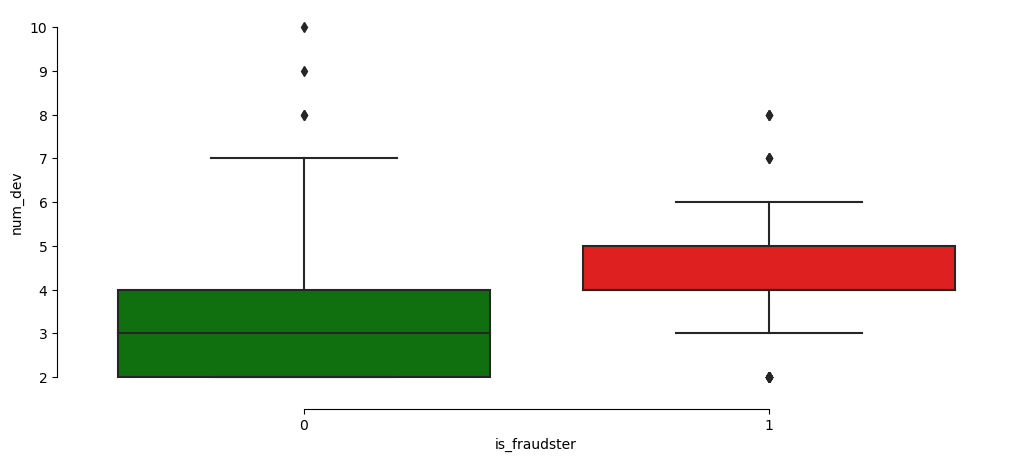

In [70]:
# проверяем предикат "количество различных физических устройств, связанных на данный момент с учетной записью"
ext_customers.dropna(inplace=True)
X = ext_customers['num_dev']
y = ext_customers['is_fraudster']
fig, ax = plt.subplots(1,figsize=(12,5))
sns.boxplot(x="is_fraudster", y="num_dev",
            palette=["g", "r"],
            data=ext_customers)
sns.despine(offset=10, trim=True)
# Этот предикат тоже хорошо подходит для обучения.

<Axes: xlabel='count', ylabel='Gender'>

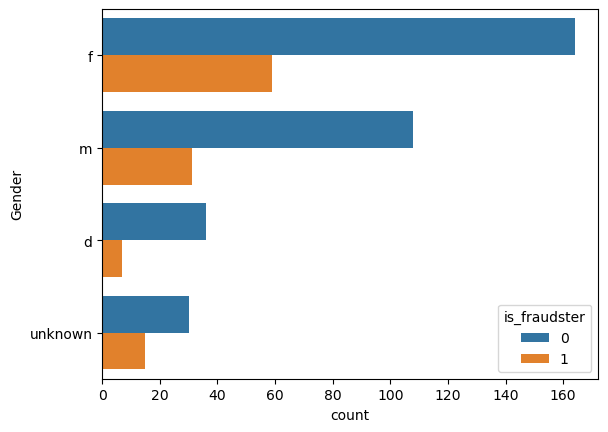

In [247]:
# проверяем предикат "пол".
ext_customers.dropna(inplace=True)
X = ext_customers['Gender']
y = ext_customers['is_fraudster']
sns.countplot(data=ext_customers, y="Gender", hue="is_fraudster")
# Можно сказать, что клиенты, за которыми были замечены мошеннические трансакции, часто не указывают свой пол. Подходит для
# обучения.

In [95]:
# Теперь начинаем обучение модели на df transaction, исходя из тех предикатов, которые я отметил, как пригодные для обучения.
X = transactions[["Dist", "payment_t", "count_dev_is_shop"]]
y = transactions["Fraudulent_trans"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
p = clf.predict_proba(X)# вероятности
results_train = clf.predict(X_train)
accuracy_score(y_train, results_train)

0.91875

In [99]:
precision_score(y_train,results_train)

0.7209302325581395

In [96]:
recall_score(y_train,results_train)

0.6019417475728155

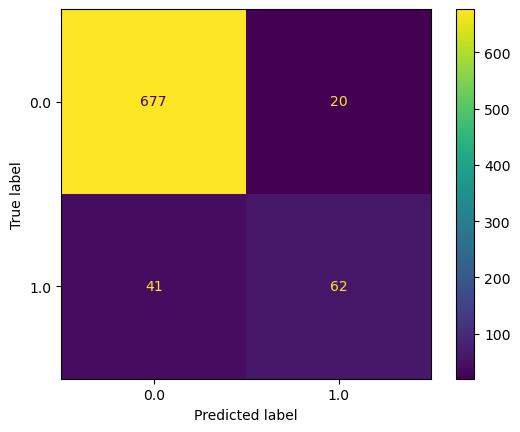

In [92]:
y_pred = clf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)

In [97]:
# В ходе экспериментов предикатами, я остановился на модели, приведённой выше. Теперь попробуем использовать эту модель 
# на тестовых данных.
results_test = clf.predict(X_test)
accuracy_score(y_test,results_test)

0.9

In [100]:
precision_score(y_test,results_test)

0.5882352941176471

In [98]:
recall_score(y_test,results_test)

0.43478260869565216

In [320]:
# Результаты на тестовый данных хуже, чем на тренировочных, но не критически хуже. Теперь построим модель, которая предсказывает 
# недобросоветсного пользователя исходя из сведённой таблицы customers со стобликом 'is_fraudster'. Тут я введу небольшую
# трансофрмацию. Т.к. обучение возможно с данными типа float, я сведу значения параметра 'Gender' к двум
# возможным - 0, если пол указан и 1, если нет.
ext_customers["is_gender"] = 0
for index, cust in ext_customers.iterrows():
    match cust['Gender']:
        case 'unknown':
            ext_customers.at[index, 'is_gender'] = 0
        case "m":
            ext_customers.at[index, 'is_gender'] = 1
        case "f":
            ext_customers.at[index, 'is_gender'] = 2
        case "d":
            ext_customers.at[index, 'is_gender'] = 3
        case _:
            ext_customers.at[index, 'is_gender'] = 0
        
X = ext_customers[["num_s", "num_dev", "is_gender"]]
y = ext_customers["is_fraudster"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
model_cust = LogisticRegression(random_state=42).fit(X_train, y_train)
p = model_cust.predict_proba(X)
results_train = model_cust.predict(X_train)
accuracy_score(y_train, results_train)

0.8027777777777778

In [313]:
precision_score(y_train,results_train)

0.7209302325581395

In [321]:
recall_score(y_train,results_train)

0.34444444444444444

In [322]:
results_test = model_cust.predict(X_test)
accuracy_score(y_test,results_test)

0.8333333333333334

In [323]:
precision_score(y_test,results_test)

0.8181818181818182

In [324]:
recall_score(y_test,results_test)

0.4090909090909091

In [257]:
# Модель по пользователям дала нам не слишком хорошие результаты предсказания потенциальных мошенников, хотя и игнорировать их
# я бы не стал. Теперь попробуем сделать обратную операцию - на основании id пользователей из таблицы customers, перенесём
# данные пользователей в таблицу transactions.
ext_transactions = transactions.copy()
ext_transactions[["num_s", "num_dev", "is_gender"]] = 0
for index, transact in ext_transactions.iterrows():
    current_customer = ext_customers[ext_customers.index == transact["Customer_id"]]
    if current_customer.size:
        ext_transactions.at[index, "num_s"] = current_customer.iloc[0]["num_s"]
        ext_transactions.at[index, "num_dev"] = current_customer.iloc[0]["num_dev"]
        ext_transactions.at[index, "is_gender"] = current_customer.iloc[0]["is_gender"]
    
ext_transactions[100:105]

,Dist,payment_t,count_dev_is_shop,basket,product_type,Customer_id,Day_of_week,Fraudulent_trans,num_s,num_dev,is_gender
transaction_id,,,,,,,,,,,
transaction_100,0.000000,1.0,0.0,34.481291,2,customer_439,6,0.0,1,2,1
transaction_101,53.530077,0.0,0.0,185.777788,1,customer_347,3,0.0,0,0,0
transaction_102,275.159339,0.0,0.0,119.955984,2,customer_538,0,0.0,1,2,0
transaction_103,126.924366,0.0,0.0,107.558556,0,customer_497,0,0.0,0,4,0
transaction_104,31.051696,0.0,0.0,119.727673,0,customer_168,5,0.0,1,4,2


<Axes: xlabel='count', ylabel='num_s'>

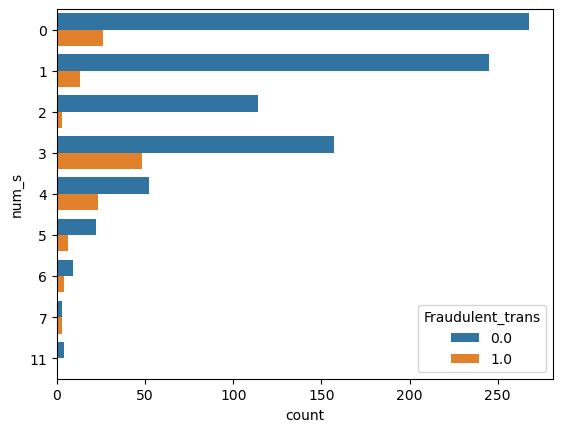

In [325]:
# проверяем предикат "количество посылок в течении месяца"
ext_customers.dropna(inplace=True)
X = ext_transactions['num_s']
y = ext_transactions['Fraudulent_trans']

sns.countplot(data=ext_transactions, y="num_s", hue="Fraudulent_trans")
# Отсюда видно, что пользователи, которые делают мошеннические трансакции, часще имеют 3-4 посылки в течении месяца.

<Axes: xlabel='count', ylabel='num_dev'>

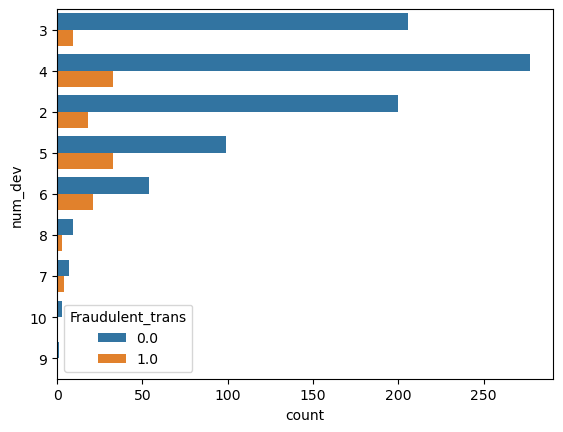

In [203]:
# проверяем предикат "количество различных физических устройств, связанных на данный момент с учетной записью"
ext_customers.dropna(inplace=True)
X = ext_transactions['num_dev']
y = ext_transactions['Fraudulent_trans']

sns.countplot(data=ext_transactions, y="num_dev", hue="Fraudulent_trans")
# Отсюда видно, что пользователи, которые делают мошеннические трансакции, часще имеют 4-6 связанных устройств. И если в случае,
# когда устройств 4, это не выделяется на общем фоне, то в случае с 5-6 картина другая.

<Axes: xlabel='count', ylabel='is_gender'>

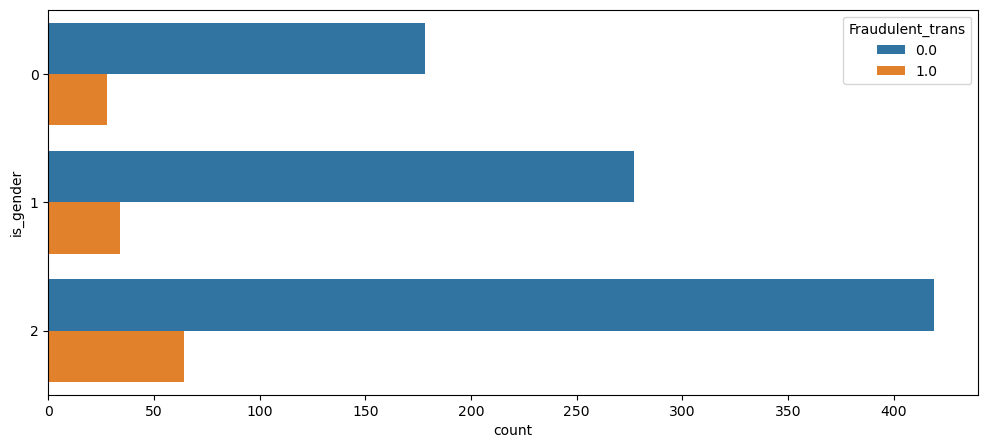

In [293]:
# проверяем предикат "указан ли пол"
ext_customers.dropna(inplace=True)
X = ext_transactions['is_gender']
y = ext_transactions['Fraudulent_trans']
fig, ax = plt.subplots(1,figsize=(12,5))
sns.countplot(data=ext_transactions, y="is_gender", hue="Fraudulent_trans")
# Соотношение примерно равное, нет смысла брать этот предикат для обучения.

In [327]:
# Сделам модель
X = ext_transactions[["Dist", "payment_t", "count_dev_is_shop", "num_dev", "is_gender"]]
y = ext_transactions["Fraudulent_trans"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
ext_transact_model = LogisticRegression(random_state=42).fit(X_train, y_train)
p = ext_transact_model.predict_proba(X)
results_train = ext_transact_model.predict(X_train)
accuracy_score(y_train, results_train)

0.92125

In [328]:
precision_score(y_train,results_train)

0.7380952380952381

In [329]:
recall_score(y_train,results_train)

0.6019417475728155

In [330]:
results_test = ext_transact_model.predict(X_test)
accuracy_score(y_test,results_test)

0.905

In [331]:
precision_score(y_test,results_test)

0.625

In [332]:
recall_score(y_test,results_test)

0.43478260869565216

In [ ]:
# По результатам расширенного обучения для тестовых данных мы добились только небольшого роста precision_score.
# accuracy_score и recall_score остались практически неизменны. Но, в сухом остатке, это лучшая модель, которая у меня получилась.
# В совокупности с моделью пользователей это может существенно сократить количество мошеннических трансакций.